In [1]:
##############################
# train with kaggle P100 GPU #
##############################

### Import Libraries

In [2]:
# general libraries
import os
import git
import shutil
import numpy as np
import pandas as pd
import seaborn as sns

# hugging face libraries
from datasets import load_dataset
from transformers import (
    AutoFeatureExtractor,
    AutoModelForImageClassification, 
    TrainingArguments, 
    Trainer
)

# pytorch libraries
import torch
from torchvision.transforms import (
    Compose, 
    Normalize,
    Resize,
    ToTensor
)

# scikit-learn libraries
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

# plotting libraries
from  matplotlib import pyplot as plt
%matplotlib inline

### Load Dataset

In [3]:
# dataset directory
######## kaggle ########
# train_dir = '/kaggle/input/ham10000-model-train-fagt-alpha-2'
# test_dir = '/kaggle/input/ham10000-model-test'

######## desktop ########
dataset_dir = os.path.abspath('../../../../datasets/HAM10000')
train_dir = os.path.join(dataset_dir, 'dataset-processed/dataset-models/ham10000-model-train-fagt-alpha-2')
test_dir = os.path.join(dataset_dir, 'split/test')

In [4]:
# load dataset
train_ds = load_dataset(train_dir)
val_ds = load_dataset(test_dir)

Resolving data files:   0%|          | 0/42294 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to C:/Users/Mominul Islam/.cache/huggingface/datasets/imagefolder/ham10000-model-train-fagt-alpha-2-a4674e9641d9326b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/828 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/Mominul Islam/.cache/huggingface/datasets/imagefolder/test-3bd1957c35eba2af/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# loaded dataset structure
print('train_ds: ', train_ds)
print('val_ds: ', val_ds)

train_ds:  DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 42294
    })
})
val_ds:  DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 828
    })
})


In [6]:
# num of training and validation samples
print('Training Samples: ', train_ds['train'].num_rows)
print('Validation Samples: ', val_ds['train'].num_rows)

Training Samples:  42294
Validation Samples:  828


In [7]:
# num of features
train_ds['train'].features['label']

ClassLabel(names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], id=None)

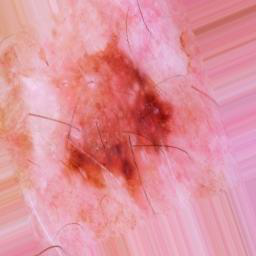

In [8]:
# show image
train_ds['train'][42]['image']

In [9]:
# show label
train_ds['train'][42]['label']

0

In [10]:
# convert labels
labels = train_ds['train'].features['label'].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [11]:
label2id

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [12]:
id2label

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

### Swin-Transformer 

In [13]:
# download pre-trained model for fine-tuning

######## kaggle ########
# path = '/kaggle/working/Swin-Transformer'

######## desktop ########
path = os.path.abspath('../../../../repository/Swin-Transformer')

if os.path.exists(path):
    print("Folder already exist!")
else:
    os.makedirs(path)
    print("Folder successfully created!")
    git.Git(path).clone('https://huggingface.co/microsoft/swin-tiny-patch4-window7-224')
    print("Repository successfully cloned!")

Folder already exist!


In [14]:
# load pre-trained model for fine-tuning

######## kaggle ########
# model_checkpoint = '/kaggle/working/Swin-Transformer/swin-tiny-patch4-window7-224'

######## desktop ########
model_checkpoint = os.path.abspath('../../../../repository/Swin-Transformer/swin-tiny-patch4-window7-224')

# feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

# Swin Transformer model
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True, 
)

C:\Anaconda\anaconda3\envs\csf-model\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of SwinForImageClassification were not initialized from the model checkpoint at D:\Research\Archive\cossif\repository\Swin-Transformer\swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# number of trainable parameters
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for Swin Transformer model: ', '{0:.6f}'.format(trainable_parameters/1000000), 'million')

Number of trainable parameters for Swin Transformer model:  27.524737 million


In [16]:
# summary of the model
model

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [17]:
normalize = Normalize(
    mean=feature_extractor.image_mean, 
    std=feature_extractor.image_std
)

######## kaggle ########
# size = feature_extractor.size

######## desktop ########
size = feature_extractor.size['height']

train_transform = Compose([
    Resize(size),
    ToTensor(),
    normalize,
])

val_transform = Compose([
    Resize(size),
    ToTensor(),
    normalize,
])

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [train_transform(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transform(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [18]:
train_set = train_ds['train']
val_set = val_ds['train']

train_set.set_transform(preprocess_train)
val_set.set_transform(preprocess_val)

In [19]:
######## desktop ########
model_dir = os.path.abspath('../../../../models/HAM10000/Swin-Transformer/ham10000-swin-fagt-alpha-2')

In [20]:
batch_size=32
lr=5e-5
epochs=10

######## kaggle ########
# output_dir = '/kaggle/working/saved_model'

######## desktop ########
output_dir = os.path.join(model_dir, 'saved_model')

args = TrainingArguments(
    output_dir=output_dir,
    remove_unused_columns=False,
    evaluation_strategy = 'steps',
    eval_steps=10,
    save_strategy = 'steps',
    save_steps=10,
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    num_train_epochs=epochs,
    optim='adamw_torch',
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_total_limit=1,
    push_to_hub=False,
    report_to='none'
)

In [21]:
def compute_sensitivity(y_true_flat, y_pred_flat):
    cm=confusion_matrix(y_true_flat, y_pred_flat)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    Sensitivity = TP/(TP+FN)    
    return np.mean(Sensitivity)

def compute_specificity(y_true_flat, y_pred_flat):
    cm=confusion_matrix(y_true_flat, y_pred_flat)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    Specificity = TN/(TN+FP)    
    return np.mean(Specificity)

In [22]:
def compute_metrics(eval_pred):
    logits, y_true_flat = eval_pred
    y_pred_flat = np.argmax(logits, axis=1)
    
    sensitivity = compute_sensitivity(y_true_flat, y_pred_flat)
    specificity = compute_specificity(y_true_flat, y_pred_flat)
    
    precision = float('{0:.6f}'.format(precision_score(y_true_flat, y_pred_flat, average='macro')))
    recall = float('{0:.6f}'.format(recall_score(y_true_flat, y_pred_flat, average='macro')))
    f1 = float('{0:.6f}'.format(f1_score(y_true_flat, y_pred_flat, average='macro')))
    accuracy = float('{0:.6f}'.format(accuracy_score(y_true_flat, y_pred_flat)))

    return {'precision': precision, 
            'recall': recall, 
            'f1': f1, 
            'sensitivity': sensitivity, 
            'specificity': specificity,
            'accuracy': accuracy
           }

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## Train

In [23]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

In [24]:
# # train model
# trainer.train()

# # creating downloads directory
# downloads = '/kaggle/working/downloads'

# if os.path.isdir(downloads):
#     print('Folder already exists!')
# else:
#     os.makedirs(downloads)
#     print('Folder created!')

# # save best model
# trainer.save_model(downloads)

# # save training log
# df = pd.DataFrame(trainer.state.log_history)
# df.to_csv('/kaggle/working/downloads/training_log.csv')

## Read CSV

In [25]:
######## kaggle ########
# df = pd.read_csv('/kaggle/working/downloads/training_log.csv')

######## desktop ########
df = pd.read_csv(os.path.join(model_dir, 'training_log.csv'))
df_backup = df

# read training log
df = df[['eval_precision', 
         'eval_recall', 
         'eval_f1', 
         'eval_sensitivity', 
         'eval_specificity',
         'eval_accuracy'
        ]].dropna()

# rename columns
df.rename(columns={'eval_precision':'Precision', 
                   'eval_recall':'Recall', 
                   'eval_f1':'F1-Score', 
                   'eval_sensitivity':'Sensitivity', 
                   'eval_specificity':'Specificity', 
                   'eval_accuracy':'Accuracy'
                  }, inplace = True)

df.head(10)

,Precision,Recall,F1-Score,Sensitivity,Specificity,Accuracy
1,0.168346,0.184368,0.060098,0.184368,0.859788,0.066425
3,0.169108,0.177977,0.074351,0.177977,0.861772,0.091787
5,0.180529,0.172159,0.097314,0.172159,0.867017,0.148551
7,0.208107,0.228791,0.160037,0.228791,0.884487,0.335749
9,0.275381,0.269135,0.217135,0.269135,0.907773,0.600242
11,0.370495,0.301988,0.290052,0.301988,0.914401,0.777778
13,0.493379,0.276991,0.290204,0.276991,0.915142,0.795894
15,0.571608,0.269313,0.302186,0.269313,0.904999,0.815217
17,0.524174,0.280517,0.310052,0.280517,0.911092,0.818841
19,0.536374,0.319788,0.346042,0.319788,0.924316,0.821256


In [26]:
# sort training log
df_sort = df.sort_values('F1-Score', ascending=False)
df_sort.head(10)

,Precision,Recall,F1-Score,Sensitivity,Specificity,Accuracy
281,0.853776,0.792985,0.815500,0.792985,0.976229,0.937198
413,0.831140,0.802360,0.813798,0.802360,0.980999,0.937198
489,0.845319,0.792325,0.812428,0.792325,0.973984,0.935990
487,0.817835,0.821884,0.810594,0.821884,0.981766,0.923913
491,0.799970,0.823337,0.810528,0.823337,0.980277,0.932367
619,0.855208,0.778143,0.807990,0.778143,0.974163,0.937198
493,0.793704,0.823556,0.805871,0.823556,0.979073,0.928744
495,0.846517,0.769081,0.801906,0.769081,0.974633,0.935990
393,0.828206,0.790938,0.800766,0.790938,0.981640,0.932367
465,0.844141,0.767058,0.799142,0.767058,0.976700,0.935990


## Performance Index

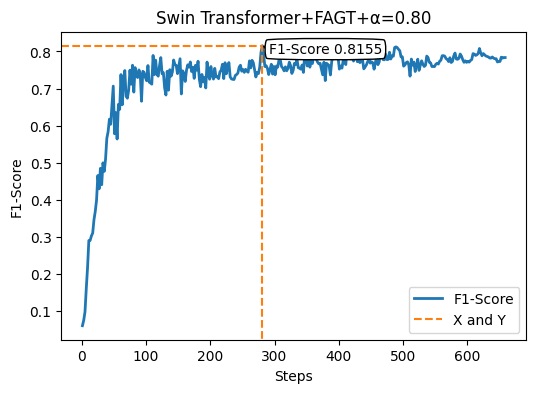

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))

x = df['F1-Score'].index.values.tolist()
y = df['F1-Score'].values.tolist()

# plot AUC 
plt.plot(x, y, lw=2)

# Find the index and coordinates of the highest point
idx = np.argmax(y)
x_max = x[idx]
y_max = y[idx]

xlim, ylim = plt.xlim(), plt.ylim()
plt.plot([x[idx], x[idx], xlim[0]], [xlim[0], y[idx], y[idx]], linestyle="--")
plt.xlim(xlim)
plt.ylim(ylim)

plt.annotate(
    'F1-Score {0:.4f}'.format(max(y)), 
    xy=(x_max, y_max), 
    xytext=(x_max + 10, y_max - 0.02),  
    bbox=dict(boxstyle="round4", fc="w"),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3, rad=-0.2", fc="w")
)

plt.title('Swin Transformer+FAGT+α=0.80')
plt.legend(['F1-Score', 'X and Y'], loc='lower right')
plt.xlabel('Steps')
plt.ylabel('F1-Score')
plt.show()

## Training Time

In [28]:
# training time 
last_row = df_backup.iloc[-1]
column_value = last_row['train_runtime']

# convert seconds to hours, minutes, and seconds
hours = int(column_value // 3600)
seconds_remaining = column_value % 3600
minutes = int(seconds_remaining // 60)
seconds = int(seconds_remaining % 60)

# print training time
print(f"Training Time: {hours}:{minutes}:{seconds}")

Training Time: 2:8:38


## Test

In [29]:
######## kaggle ########
# save_path = '/kaggle/working/downloads'
# load_model = save_path

######## desktop ########
save_path = os.path.join(model_dir, 'saved_model')
load_model = save_path

In [30]:
trained_model = AutoModelForImageClassification.from_pretrained(
    load_model, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, 
)

In [31]:
tester = Trainer(
    model=trained_model,
    args=args,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

In [32]:
tester.evaluate()

{'eval_loss': 0.23300713300704956,
 'eval_precision': 0.853776,
 'eval_recall': 0.792985,
 'eval_f1': 0.8155,
 'eval_sensitivity': 0.7929850200949946,
 'eval_specificity': 0.9762294024718535,
 'eval_accuracy': 0.937198,
 'eval_runtime': 29.0465,
 'eval_samples_per_second': 28.506,
 'eval_steps_per_second': 0.895}

In [33]:
predictions = tester.predict(test_dataset=val_set).predictions

In [34]:
def to_categorical(y, num_classes):
    """ 1-hot encoding """
    return np.eye(num_classes, dtype='uint8')[y]

def test_set(val_set):
    y = []
    for i in range(val_set.num_rows):
        y.append(val_set[i]['label'])
    return np.array(y)

In [35]:
############## true ##############
# y_true_flat
y_true_flat = test_set(val_set)

# y_true
y_true = to_categorical(y_true_flat, 7)

############## predicted ##############
# y_pred_flat
y_pred_flat = np.argmax(predictions, axis=-1)

# y_pred
y_pred = predictions

In [36]:
############## ROC AUC ##############
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

for i in range(7):
    print(f"{classes[i]} AUC: ", '{0:.4f}'.format(roc_auc_score(y_true[:, i], y_pred[:, i])))

akiec AUC:  0.9843
bcc AUC:  0.9964
bkl AUC:  0.9554
df AUC:  0.9957
mel AUC:  0.8820
nv AUC:  0.9894
vasc AUC:  0.9987


In [37]:
print("Average AUC: ", '{0:.2f}%'.format(roc_auc_score(y_true, y_pred)*100))

Average AUC:  97.17%


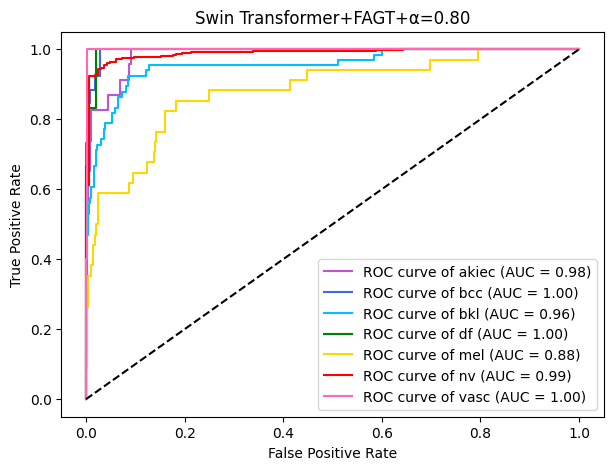

In [38]:
############## AUC ##############
fig, ax = plt.subplots(figsize=(7, 5))

classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
colours = ['mediumorchid', 'royalblue', 'deepskyblue', 'green', 'gold', 'red', 'hotpink']

for i in range(7):
    RocCurveDisplay.from_predictions(
        y_true[:, i],
        y_pred[:, i],
        name=f'ROC curve of {classes[i]}',
        color=colours[i],
        ax=ax
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Swin Transformer+FAGT+α=0.80")
plt.legend()
plt.show()

In [39]:
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

report = classification_report(y_true_flat, y_pred_flat, target_names=classes)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.77      0.74      0.76        23
         bcc       0.82      0.88      0.85        26
         bkl       0.90      0.67      0.77        66
          df       1.00      0.67      0.80         6
         mel       0.62      0.71      0.66        34
          nv       0.97      0.99      0.98       663
        vasc       0.90      0.90      0.90        10

    accuracy                           0.94       828
   macro avg       0.85      0.79      0.82       828
weighted avg       0.94      0.94      0.94       828



In [40]:
sensitivity = '{0:.2f}'.format(compute_sensitivity(y_true_flat, y_pred_flat)*100)
specificity = '{0:.2f}'.format(compute_specificity(y_true_flat, y_pred_flat)*100)
    
precision = '{0:.2f}'.format(precision_score(y_true_flat, y_pred_flat, average='macro')*100)
recall = '{0:.2f}'.format(recall_score(y_true_flat, y_pred_flat, average='macro')*100)
f1 = '{0:.2f}'.format(f1_score(y_true_flat, y_pred_flat, average='macro')*100)
accuracy = '{0:.2f}'.format(accuracy_score(y_true_flat, y_pred_flat)*100)

matrix_log = [[precision, recall, f1, accuracy, sensitivity, specificity]]
df_result = pd.DataFrame(
    matrix_log, 
    columns=[
        'Precision (%)',
        'Recall (%)', 
        'F1-Score (%)',
        'Accuracy (%)', 
        'Sensitivity (%)', 
        'Specificity (%)'
    ])

df_result = df_result.style.hide(axis='index')
df_result

Precision (%),Recall (%),F1-Score (%),Accuracy (%),Sensitivity (%),Specificity (%)
85.38,79.30,81.55,93.72,79.30,97.62


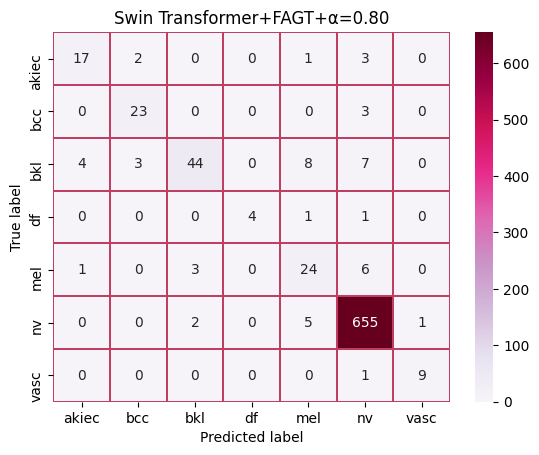

In [41]:
cnf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]

labels = [f"{v1}" for v1 in group_counts]

matrix_labels = np.asarray(labels).reshape(7,7)
axis_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

ax = sns.heatmap(
    cnf_matrix, 
    annot=matrix_labels, 
    fmt='',  
    cmap='PuRd', 
    linewidths=0.1, 
    linecolor=(191/255, 62/255, 98/255),
    xticklabels=axis_labels, 
    yticklabels=axis_labels
)

sns_figure = ax.set(xlabel='Predicted label', ylabel='True label', title='Swin Transformer+FAGT+α=0.80')

In [42]:
######## kaggle ########
# downloads = '/kaggle/working/downloads'

# source = downloads
# destination = downloads

# shutil.make_archive(destination, 'zip', source)

In [43]:
###################################################################
# Download the script and folder named 'downloads'.               # 
#                                                                 #
# The 'downloads' folder contains:                                #
#  - the training log file (training_log.csv)                     #
#  - the trained model (saved_model)                              #
#                                                                 #
# Rename the 'downloads' folder to the associated script name.    #
#                                                                 # 
# Move the renamed folder and the script to the current workspace.#
# ----------------------------------------------------------------#
# - models                                                        #
#  - HAM10000                                                     #
#   - Swin-Transformer                                            #
#    - ham10000-swin-fagt-alpha-2                                 #
# ----------------------------------------------------------------#
# - scripts                                                       #
#  - HAM10000                                                     #
#   - HAM10000_model_train                                        #
#    - Swin-Transformer                                           #
#     - ham10000-swin-fagt-alpha-2.ipynb                          #
###################################################################